<a href="https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/a1/execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assigment 1 execution

Corpora: https://www.nltk.org/nltk_data/ , point 91, "Dependency Parsed Treebank" ([link](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip)).

Docs:
* https://www.nltk.org/api/nltk.corpus.html
* https://www.nltk.org/data.html
* https://www.nltk.org/install.html

## Preparing the environment

In [1]:
%pip install pandas numpy matplotlib gensim tensorflow-addons

/bin/bash: /home/daniele/.miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, shutil  #  file management
import sys 
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation
import re
import urllib.request  # download files
from zipfile import ZipFile # extract files
from matplotlib import pyplot as plt
import tensorflow_addons as tfa
from sklearn.metrics import f1_score
import keras

2022-12-08 21:29:20.341980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 21:29:22.158437: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-08 21:29:25.088258: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/daniele/.miniconda3/envs/tf/lib/
2022-12-08 21:29:25.088447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plu

## Downloading the dataset

In [3]:
#from nltk import download
#download()

In [4]:
dataset_folder = os.path.join(os.getcwd(), "Dataset")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")
    
with ZipFile(dataset_path, 'r') as zObject:
  # Extracting all the members of the zip  into a specific location.
  zObject.extractall(dataset_folder)
  print("Successful extraction")

Successful extraction


## Loading the data

In [5]:
#from nltk.corpus import dependency_treebank
#from nltk.data import load
#dependency_treebank_test = load("nltk:") 
#sentences = dependency_treebank.sents()
#words = dependency_treebank.words()

In [6]:
def loadCorpus(start, stop=None):
    '''
    Loads the data for the specified file range.
    
    Removes the third column 'num', which is not necessary for this task.

    Parameters:
        start: start of numeric range of files (inclusive)
        stop: end of numeric range of files (exclusive)
    '''
    dataset_name = "dependency_treebank"
    folder = os.path.join(os.getcwd(), "Dataset", dataset_name)

    if stop==None:
        stop = start+1
    
    return pd.concat([
        pd.read_csv(
            f'{folder}/wsj_{"{:04d}".format(num)}.dp',
            sep="\t",
            usecols=[0,1],
            names=["word","label"]
        ) for num in range(start, stop)
    ])

In [7]:
full_dataset = loadCorpus(1,200)

## Exploratory Data Analysis

In [8]:
full_dataset.count()

word     94084
label    94084
dtype: int64

In [9]:
full_dataset.head(10)

,word,label
0,Pierre,NNP
1,Vinken,NNP
2,",",","
3,61,CD
4,years,NNS
5,old,JJ
6,",",","
7,will,MD
8,join,VB
9,the,DT


Each document contains a different tokenized article:

In [10]:
" ".join(loadCorpus(1)["word"])

'Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 . Mr. Vinken is chairman of Elsevier N.V. , the Dutch publishing group .'

In [11]:
" ".join(loadCorpus(2)["word"])

'Rudolph Agnew , 55 years old and former chairman of Consolidated Gold Fields PLC , was named a nonexecutive director of this British industrial conglomerate .'

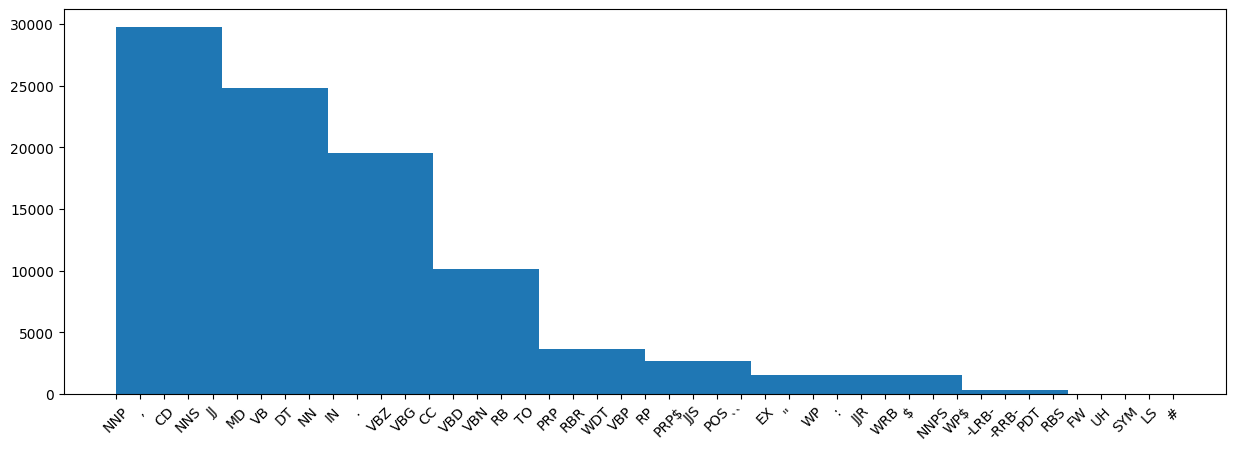

In [12]:
fig=plt.figure(figsize=(15,5))
p = plt.hist(full_dataset["label"])
plt.xticks(rotation=45)
plt.show()

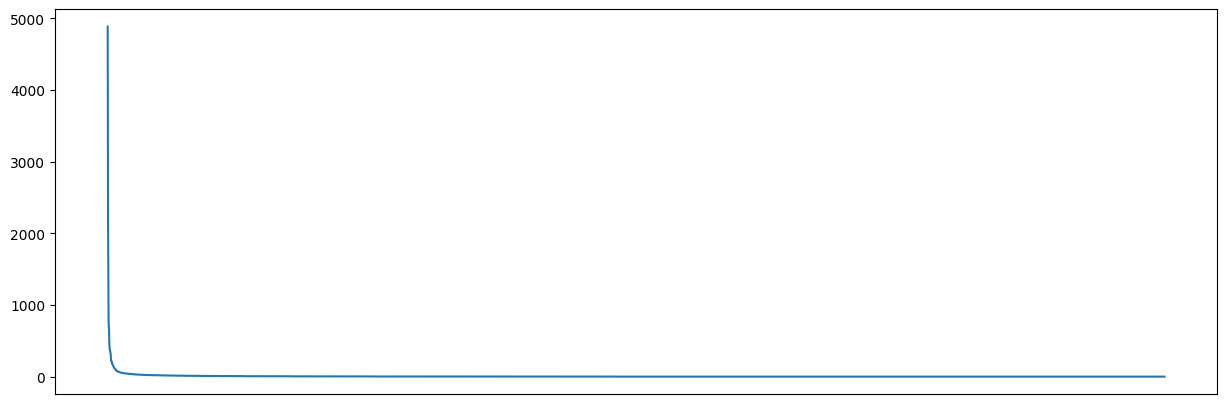

In [13]:
fig=plt.figure(figsize=(15,5))
p = plt.plot(full_dataset["word"].value_counts())
plt.xticks([])
plt.show()

## Data splitting





Creation of train, validation and test sets.

In [14]:
df_train = loadCorpus(1,101) 
df_val = loadCorpus(101,151)
df_test = loadCorpus(151,200)

df_train.count()

word     47356
label    47356
dtype: int64

In [15]:
df_val.count()

word     31183
label    31183
dtype: int64

In [16]:
df_test.count()

word     15545
label    15545
dtype: int64

## Data pre-processing

Clean the data.

In [17]:
def cleanCorpus(corpus):
    corpus['word'] = corpus['word'].str.lower()
    corpus["word"] = [re.sub(r'[^\w]', '', word) for word in corpus["word"]]
    corpus = corpus[corpus["word"] != ""]
    return corpus

In [18]:
#cleaned dataframes
dfc_train = cleanCorpus(df_train)
dfc_val = cleanCorpus(df_val)
dfc_test = cleanCorpus(df_test)

dfc_train.count()

word     41149
label    41149
dtype: int64

In [19]:
dfc_val.count()

word     27263
label    27263
dtype: int64

In [20]:
dfc_test.count()

word     13614
label    13614
dtype: int64

In [21]:
dfc_train.head(10)

,word,label
0,pierre,NNP
1,vinken,NNP
3,61,CD
4,years,NNS
5,old,JJ
7,will,MD
8,join,VB
9,the,DT
10,board,NN
11,as,IN


## Word embedding

### Loading GloVe


Loading pre-trained dense word embedding: Glove.






In [22]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [23]:
# Modify these variables as you wish!
# Glove -> 50, 100, 200, 300
# Word2Vec -> 300
# Fasttext -> 300
embedding_model = load_embedding_model(model_type="glove", embedding_dimension=50)

### Analyzing OOV statistics

In [24]:
embedding_model.index_to_key[0:10]

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]

In [25]:
oov_train = list(set([word for word in dfc_train.word.values if word not in embedding_model.index_to_key]))
oov_val = list(set([word for word in dfc_val.word.values if word not in embedding_model.index_to_key]))

len(oov_train)

535

In [26]:
len(oov_val)

305

In [27]:
oov_train[0:10]

['collectivebargaining',
 '325000',
 '271124',
 'newhome',
 'hardcharging',
 '14308',
 'smallcompany',
 'maleonly',
 'heavyduty',
 '120000']

### Embedding with GloVe

#### Prepare the embedding matrix

Definition of a tokenizer.

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer

# define the tokenizer
tokenizer = Tokenizer(oov_token='<unk>')
text = dfc_train.word.values

#fit the tokenizer on the training data
tokenizer.fit_on_texts(text)

# number of unique words in dict.
print("Number of unique words in dictionary=", len(tokenizer.word_index))
print("Dictionary head: ", dict(list(tokenizer.word_index.items())[0:10]))

Number of unique words in dictionary= 7305
Dictionary head:  {'<unk>': 1, 'the': 2, 'of': 3, 'a': 4, 'to': 5, 'in': 6, 'and': 7, 'for': 8, 's': 9, 'that': 10}


In [ ]:
with open('./Dataset/word_index.json','w') as word_index_file:
    word_index_file.write(tokenizer.to_json())

Define the embedding matrix.

In [29]:
from tqdm import tqdm

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx,
                           vocab_size: int) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(tokenizer.word_index.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            #print(f"Using random vector for '{word}'")
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [30]:
# Testing
embedding_dimension = 50
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, tokenizer.word_index, vocab_size )
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 7305/7305 [00:00<00:00, 129121.04it/s]

Embedding matrix shape: (7306, 50)


#### Encode the dataset

Define a label encoder for the target class.

In [31]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
dfc_train['encoded_label'] = le.fit_transform(dfc_train['label'])
dfc_val['encoded_label'] = le.transform(dfc_val['label'])
dfc_test['encoded_label'] = le.transform(dfc_test['label'])

/tmp/ipykernel_1448/353797677.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc_train['encoded_label'] = le.fit_transform(dfc_train['label'])
/tmp/ipykernel_1448/353797677.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc_val['encoded_label'] = le.transform(dfc_val['label'])
/tmp/ipykernel_1448/353797677.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [32]:
dfc_train.head(10)

,word,label,encoded_label
0,pierre,NNP,16
1,vinken,NNP,16
3,61,CD,5
4,years,NNS,18
5,old,JJ,10
7,will,MD,14
8,join,VB,29
9,the,DT,6
10,board,NN,15
11,as,IN,9


Transform the text into a sequence of integers using the tokenizer defined before. 

In [33]:
x_train = np.array(tokenizer.texts_to_sequences(dfc_train.word.values)) 
y_train =np.array( dfc_train['encoded_label'])

x_val = np.array(tokenizer.texts_to_sequences(dfc_val.word.values))
y_val = np.array(dfc_val['encoded_label'])

x_test = np.array(tokenizer.texts_to_sequences(dfc_test.word.values))
y_test = np.array(dfc_test['encoded_label'])

#number of unique labels
num_classes = len(np.unique(y_train))
num_classes


39

In [34]:

vocab_size = len(tokenizer.word_index) + 1
vocab_size

7306

Pad the sequences to make them of same length before passing them to the model.

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=1, padding='post')
x_val = pad_sequences(x_val, maxlen=1, padding='post')
x_test = pad_sequences(x_test, maxlen=1, padding='post')

#Train
print(f'X train shape: {x_train.shape}')
print(f'Y train shape: {y_train.shape}')
print(f'type:{type(x_train)}')

# Val
print(f'X val shape: {x_val.shape}')
print(f'Y val shape: {y_val.shape}')
print(f'type:{type(y_train)}')
# Test

print(f'X test shape: {x_test.shape}', x_test.shape)
print(f'Y test shape: {y_test.shape}', y_test.shape)

X train shape: (41149, 1)
Y train shape: (41149,)
type:<class 'numpy.ndarray'>
X val shape: (27263, 1)
Y val shape: (27263,)
type:<class 'numpy.ndarray'>
X test shape: (13614, 1) (13614, 1)
Y test shape: (13614,) (13614,)


## Utility methods

In [36]:
from tensorflow import keras
from tensorflow.keras import layers
from typing import List, Dict, Callable


def create_model(layers_info: List[Dict], compile_info: Dict) -> keras.Model:
    """
    Create a Keras model given a list of layer information

    :param layers_info: a list of dictionaries, one for each layer
    :param compile_info: dictionary containing compile information

    :return
        model: the built keras sequential model
    """

    model = keras.Sequential()
    for _, info in enumerate(layers_info):
        layer = info['mlayer'](**{key: value for key, value in info.items() if key != 'mlayer'})
        model.add(layer)

    model.summary()
    model.compile(**compile_info)
    return model

In [37]:
import matplotlib.pyplot as plt
from functools import partial
from keras.callbacks import History

def show_history(history: History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """
    history_data = history.history
    print(f"Displaying the following history keys: {history_data.keys()}")
    
    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if f'val_{key}' in history_data:
                ax.plot(history_data[f'val_{key}'])
            else:
                print(f"Couldn't find validation values for metric: {key}")

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')
            plt.grid(True)
        plt.show()

In [38]:
def train_model(model: keras.Model, training_info: Dict):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """

    print(f"Start training! \nParameters: {training_info}")

    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        **training_info)
    print("Training completed!")

    print("Showing history...")
    show_history(history)

    return model

In [39]:
def predict_data(model: keras.Model,
                x: np.ndarray,
                prediction_info: Dict):
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """
    print(f'Starting prediction: \n{prediction_info}')
    print(f'Predicting on {x.shape[0]} samples')
    predictions = model.predict(x, **prediction_info)
    return predictions

In [40]:
from sklearn.metrics import f1_score

def compute_f1(model: keras.Model, 
             x: np.ndarray, 
             y: np.ndarray):
    """
    Compute F1_score on the given data with corresponding labels

    :param model: Keras built and possibly trained model
    :param x: data in np.ndarray format
    :param y: ground-truth labels in np.ndarray format

    :return
        score: f1_macro_score
    """
    #predictions on the x set
    prediction_info = {
        'batch_size': 64,
        'verbose': 1
    }
    y_pred = predict_data(model=model, x=x, prediction_info=prediction_info)

    #compute argmax to take the best class for each sample
    y_pred = np.argmax(y_pred, axis=1)
    #compute the f1_macro
    score = f1_score(y, y_pred, average ='macro')
    return score

## Baseline model: LSTM

### Define the model

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional 
from tensorflow.keras.optimizers import Adam

base_layers_info = [
    {
        "mlayer": layers.Embedding,        
        'input_dim': vocab_size,
        "output_dim" : embedding_dimension,
        "input_length" : 1,
        "weights" : [embedding_matrix],
        "trainable" : False,
        "name" : "embedding_layer"
    },
    {
        "mlayer": layers.Bidirectional,
        "layer": LSTM(32),
        "name" : 'LSTM'
    },
    {
        "mlayer": layers.Dense,
        "units": num_classes,
        "activation" : 'softmax',
        'name' : 'logits'
    }
]

base_compile_info = {
    'optimizer': Adam(),
    'loss': 'sparse_categorical_crossentropy',
    'metrics': ['accuracy']
}

base_model = create_model(base_layers_info, base_compile_info)

2022-12-08 21:30:05.192658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-08 21:30:05.505270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-08 21:30:05.505661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-08 21:30:05.507992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 1, 50)            365300    
                                                                 
 LSTM (Bidirectional)        (None, 64)                21248     
                                                                 
 logits (Dense)              (None, 39)                2535      
                                                                 
Total params: 389,083
Trainable params: 23,783
Non-trainable params: 365,300
_________________________________________________________________


Start training! 
Parameters: {'verbose': 0, 'epochs': 30, 'batch_size': 64}


2022-12-08 21:30:23.986579: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


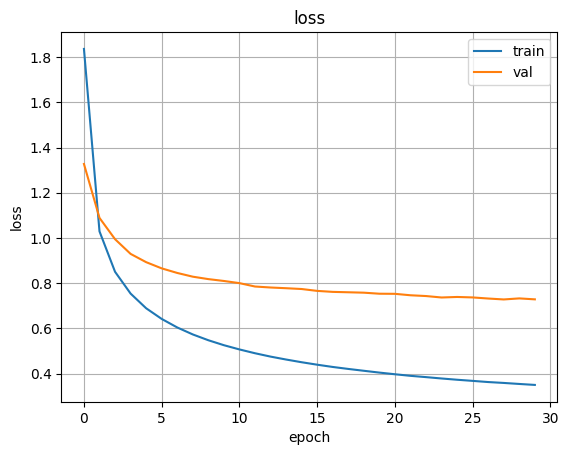

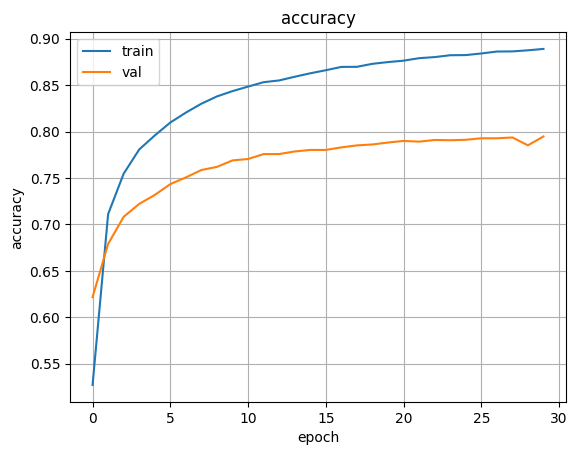

In [42]:
# Train
 
base_training_info = {
    'verbose': 0,
    'epochs' : 30,
    'batch_size' : 64
}

base_model = train_model(model=base_model,training_info = base_training_info)

In [43]:
type(base_model)

keras.engine.sequential.Sequential

#### F1-Macro evaluation

In [44]:
loss, accuracy = base_model.evaluate(x_val, y_val)
print(f"Model loss: {loss}, accuracy: {accuracy}")

# Inference and evaluate

base_score = compute_f1(base_model, x_val, y_val)
print(f'F1_score on the validation set is: {base_score}')

base_score = compute_f1(base_model, x_test, y_test)
print(f'F1_score on the test set is: {base_score}')

852/852 [==============================] - 8s 10ms/step - loss: 0.7287 - accuracy: 0.7947
Model loss: 0.728701114654541, accuracy: 0.7947034239768982
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 27263 samples
426/426 [==============================] - 4s 7ms/step
F1_score on the validation set is: 0.6639380043209953
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 13614 samples
213/213 [==============================] - 2s 7ms/step
F1_score on the test set is: 0.7343330813952944


In [45]:
y_val.shape

(27263,)

In [46]:
onehot = OneHotEncoder(sparse=False)
onehot.fit(y_train.reshape(-1,1))
y_val_onehot = onehot.transform(y_val.reshape(-1,1))
y_val_onehot.shape

(27263, 39)

In [47]:
y_pred_val = base_model.predict(x_val)
y_pred_val.shape

852/852 [==============================] - 7s 8ms/step


(27263, 39)

In [48]:
# https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
f1_macro = tfa.metrics.F1Score(average="macro", num_classes=num_classes, threshold=0.5)
f1_macro.update_state(y_val_onehot, y_pred_val)
f1_macro.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.6439411>

## Model A: GRU

GRU is a simpler alternative to LSTM's architecture, less effective but with a faster train.
</br>Two layers architecture: a Bidirectional GRU layer and a Dense/FC layer on top. 

In [49]:
# Create model

from tensorflow.keras.layers import GRU

gru_layers_info = [
    {
        "mlayer": layers.Embedding,
        "output_dim" : embedding_dimension,
        "input_dim" : vocab_size,
        "input_length" : 1,
        "weights" : [embedding_matrix],
        "trainable" : False,
        "name" : "embedding"
    },
    {
        "mlayer": layers.Bidirectional,
        "layer": GRU(32) , 
        'name' : 'GRU'     
    },
    {
        "mlayer": layers.Dense,
        "units":num_classes,
        "activation" : 'softmax',
        'name' : 'logits'
    }
]

gru_compile_info = {
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'sparse_categorical_crossentropy',
    'metrics': ['accuracy']
}

gru_model = create_model(gru_layers_info, gru_compile_info)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 50)             365300    
                                                                 
 GRU (Bidirectional)         (None, 64)                16128     
                                                                 
 logits (Dense)              (None, 39)                2535      
                                                                 
Total params: 383,963
Trainable params: 18,663
Non-trainable params: 365,300
_________________________________________________________________


Start training! 
Parameters: {'verbose': 0, 'epochs': 30, 'batch_size': 64}
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


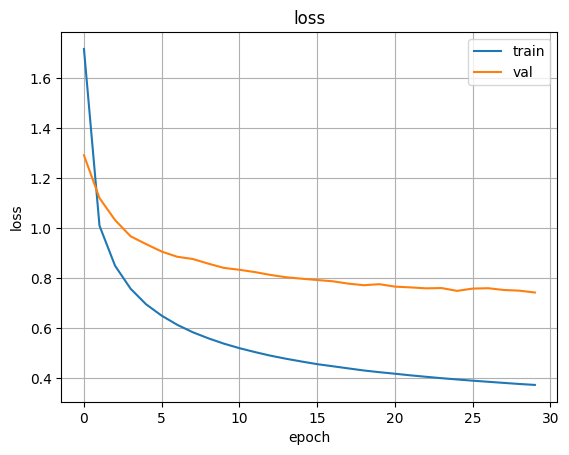

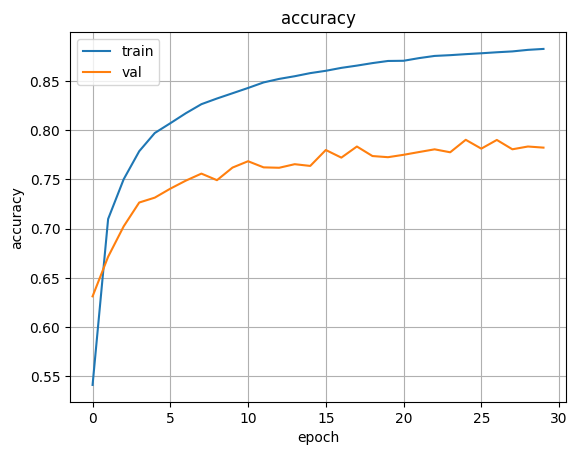

In [50]:
# Train
 
gru_training_info = {
    'verbose': 0,
    'epochs' : 30,
    'batch_size' : 64
}

gru_model = train_model(model=gru_model,training_info = gru_training_info)

#### F1-Macro evaluation

In [51]:
loss, accuracy = gru_model.evaluate(x_val, y_val)
print(f"Model loss: {loss}, accuracy: {accuracy}")

# Inference and evaluate

gru_score = compute_f1(gru_model, x_val, y_val)
print(f'F1_score on the validation set is: {gru_score}')

gru_score = compute_f1(gru_model, x_test, y_test)
print(f'F1_score on the test set is: {gru_score}')

852/852 [==============================] - 12s 14ms/step - loss: 0.7421 - accuracy: 0.7823
Model loss: 0.7420722246170044, accuracy: 0.7823423743247986
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 27263 samples
426/426 [==============================] - 5s 9ms/step
F1_score on the validation set is: 0.6719640675584716
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 13614 samples
213/213 [==============================] - 2s 8ms/step
F1_score on the test set is: 0.7345519702957185


## Model B: 2x LSTM 

A dictionary with some hyperparameters to test on the LSTM layers. At the end of the process, for each of the models, the f1_macro will be printed.

In [52]:
hp_b = {
    'hp1_1' : {
        'lstm_1' : {
            'units' : 14,
            'return_sequences' : True,
            'dropout' : 0.1
        },
        'lstm_2' : {
            'units' : 28,
            'return_sequences' : False,
            'dropout' : 0.1
        },
        'learning_rate' : 1.5e-3
    },
    'hp1_2' : {
        'lstm_1' : {
            'units' : 14,
            'return_sequences' : True,
            'dropout' : 0
        },
        'lstm_2' : {
            'units' : 28,
            'return_sequences' : False,
            'dropout' : 0
        },
        'learning_rate' : 1.5e-3
    },
    'hp2_1' : {
        'lstm_1' : {
            'units' : 28,
            'return_sequences' : True,
            'dropout' : 0.1
        },
        'lstm_2' : {
            'units' : 14,
            'return_sequences' : False,
            'dropout' : 0.1
        },
        'learning_rate' : 1.5e-3
    },
    'hp2_2' : {
        'lstm_1' : {
            'units' : 28,
            'return_sequences' : True,
            'dropout' : 0
        },
        'lstm_2' : {
            'units' : 14,
            'return_sequences' : False,
            'dropout' : 0
        },
        'learning_rate' : 1.5e-3
    },
    'hp3' : {
        'lstm_1' : {
            'units' : 24,
            'return_sequences' : True,
            'dropout' : 0.1
        },
        'lstm_2' : {
            'units' : 24,
            'return_sequences' : False,
            'dropout' : 0.1
        },
        'learning_rate' : 1.5e-3
    }
}

Function for f1_macro calculation.

In [53]:
def f1_macro(model, y_train, y_val, num_classes):
    onehot = OneHotEncoder(sparse=False)
    onehot.fit(y_train.reshape(-1,1))
    y_val_onehot = onehot.transform(y_val.reshape(-1,1))

    y_pred_val = model.predict(x_val)

    # https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
    f1_macro = tfa.metrics.F1Score(average="macro", num_classes=num_classes, threshold=0.5)
    f1_macro.update_state(y_val_onehot, y_pred_val)
    return f1_macro.result()

This array will store all the f1_scores calculated with the function above.

In [54]:
results_x2lstm = []

Setup of the loop for creation, fit, evaluation of the 2xLSTM models with the dictionary of hyperparameters.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 50)             365300    
                                                                 
 bidirectional (Bidirectiona  (None, 1, 28)            7280      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 56)               12768     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 39)                2223      
                                                                 
Total params: 387,571
Trainable params: 22,271
Non-trainable params: 365,300
_________________________________________________________________
Epoch 1/30
322/322 [=======================

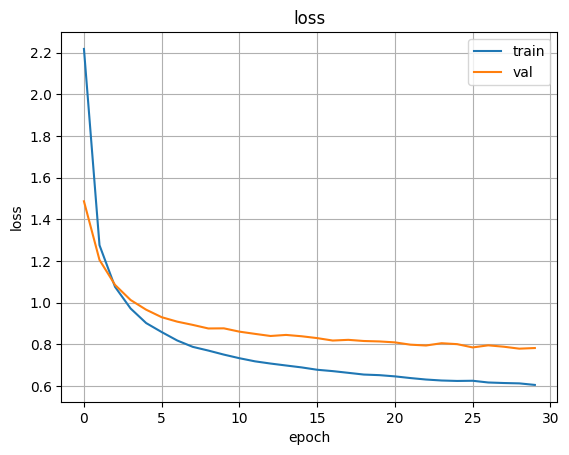

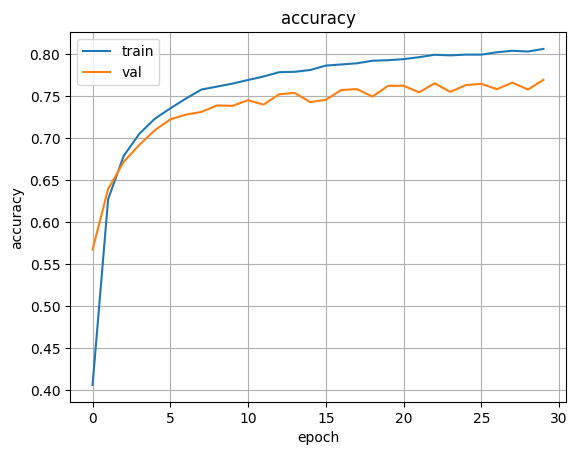

852/852 [==============================] - 14s 14ms/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1, 50)             365300    
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 28)            7280      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 56)               12768     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 39)                2223      
                                                                 
Total params: 387,571
Trainable params: 22,271
Non-trainable params: 365,300
____________________________________________________

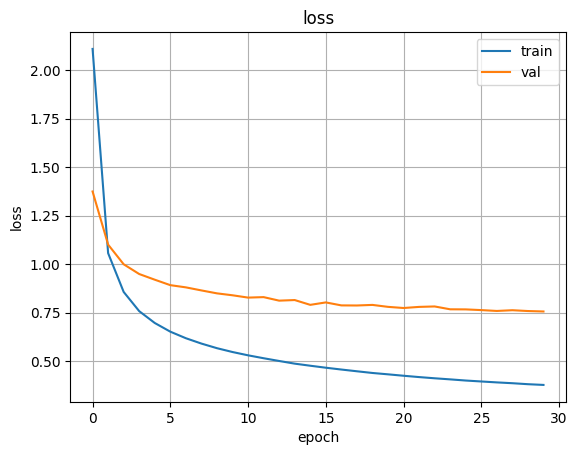

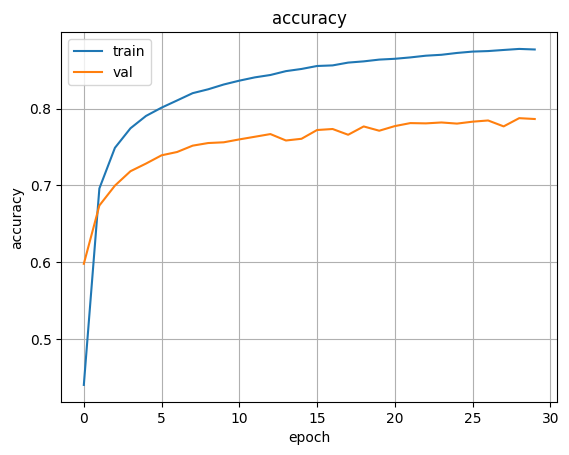

852/852 [==============================] - 12s 12ms/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1, 50)             365300    
                                                                 
 bidirectional_4 (Bidirectio  (None, 1, 56)            17696     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 28)               7952      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 39)                1131      
                                                                 
Total params: 392,079
Trainable params: 26,779
Non-trainable params: 365,300
____________________________________________________

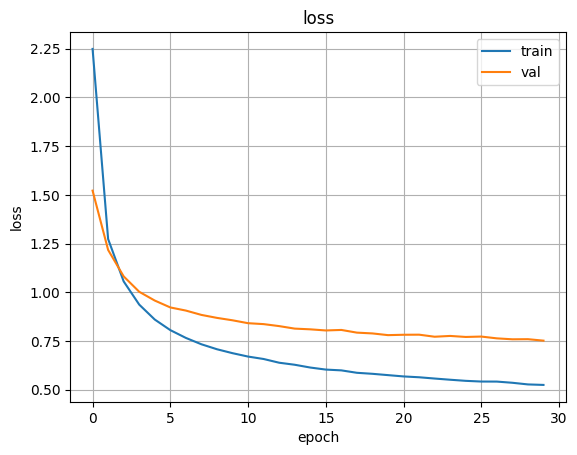

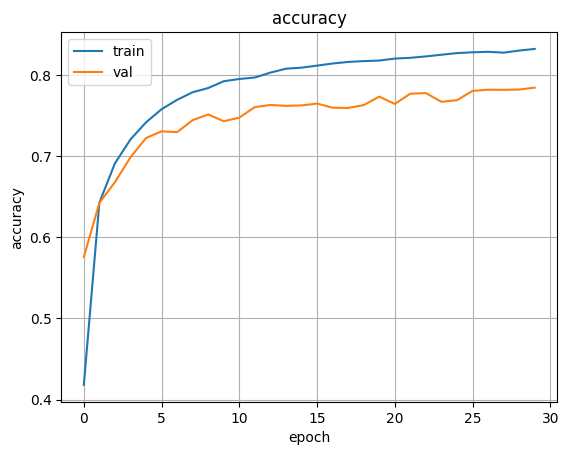

852/852 [==============================] - 11s 12ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1, 50)             365300    
                                                                 
 bidirectional_6 (Bidirectio  (None, 1, 56)            17696     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 28)               7952      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 39)                1131      
                                                                 
Total params: 392,079
Trainable params: 26,779
Non-trainable params: 365,300
____________________________________________________

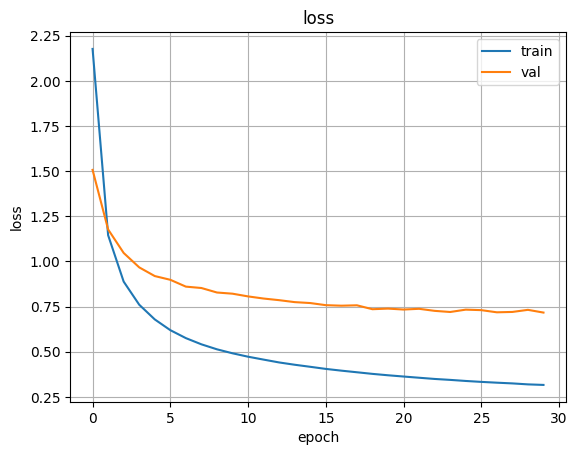

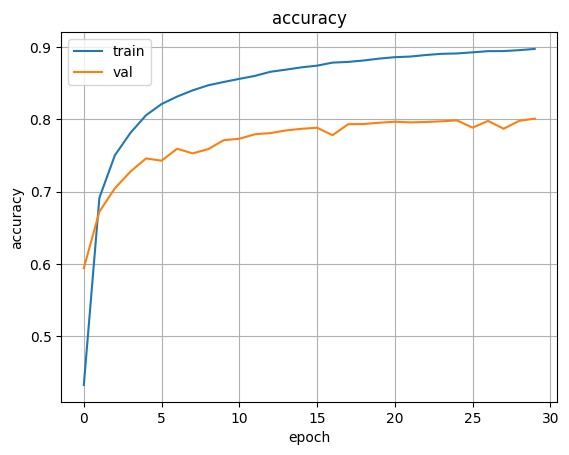

852/852 [==============================] - 12s 12ms/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1, 50)             365300    
                                                                 
 bidirectional_8 (Bidirectio  (None, 1, 48)            14400     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 48)               14016     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 39)                1911      
                                                                 
Total params: 395,627
Trainable params: 30,327
Non-trainable params: 365,300
____________________________________________________

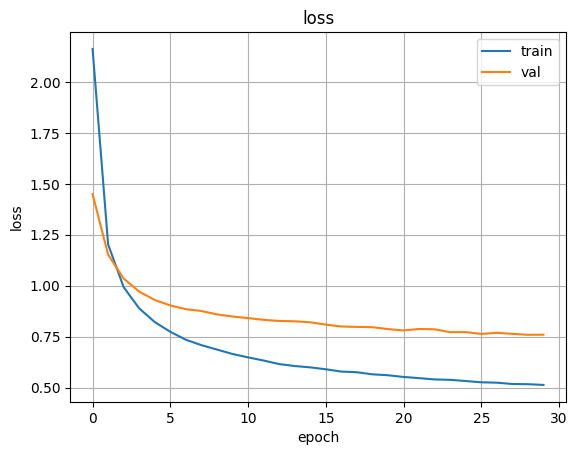

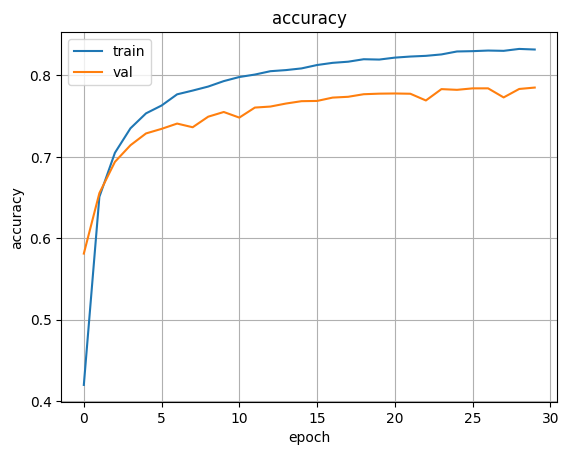

852/852 [==============================] - 13s 13ms/step


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional 
from keras.optimizers import Adam


for key,idx in zip(hp_b.keys(),range(0,5)):
    l1 = hp_b[key]['lstm_1']
    l2 = hp_b[key]['lstm_2']
    learning_rate = hp_b[key]['learning_rate']

    x2lstm_model = Sequential()
    embedding_layer = Embedding(input_dim = vocab_size,output_dim= embedding_dimension,input_length=1, weights = [embedding_matrix], trainable = False)
    x2lstm_model.add(embedding_layer)
    x2lstm_model.add(Bidirectional(LSTM(
                                    units=l1['units'], 
                                    return_sequences=l1['return_sequences'],
                                    dropout=l1['dropout'])))
    
    x2lstm_model.add(Bidirectional(LSTM(
                                    units=l2['units'], 
                                    return_sequences=l2['return_sequences'],
                                    dropout=l2['dropout'])))
    x2lstm_model.add(Dense(num_classes,activation='softmax'))

    x2lstm_model.summary()

    x2lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    # fit model
    history = x2lstm_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size = 128, epochs=30)
    print('='*40,key,'='*40)
    show_history(history)
    x2lstm_model.evaluate(x_val, y_val)
    results_x2lstm.append(f1_macro(x2lstm_model, y_train, y_val, num_classes))

In [56]:
print("F1_SCORES")
for f1_macro_score,idx in zip(results_x2lstm,range(0,5)):
    print(idx, " ", f1_macro_score)

F1_SCORES
0   tf.Tensor(0.6258778, shape=(), dtype=float32)
1   tf.Tensor(0.6487233, shape=(), dtype=float32)
2   tf.Tensor(0.628033, shape=(), dtype=float32)
3   tf.Tensor(0.6553935, shape=(), dtype=float32)
4   tf.Tensor(0.64292634, shape=(), dtype=float32)


In [57]:
#from keras.optimizers import Adam

#x2lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=2e-3), metrics=['accuracy'])

In [58]:
# fit model
#history = x2lstm_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size = 128, epochs=30)

In [59]:
#show_history(history)

In [60]:
#x2lstm_model.evaluate(x_val, y_val)

## Model C: LSTM + Dense

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional 
from tensorflow.keras.optimizers import Adam

lstm_dense_layers_info = [
    {
        "mlayer": layers.Embedding,        
        'input_dim': vocab_size,
        "output_dim" : embedding_dimension,
        "input_length" : 1,
        "weights" : [embedding_matrix],
        "trainable" : False,
        "name" : "embedding_layer"
    },
    {
        "mlayer": layers.Bidirectional,
        "layer": LSTM(32),
        "name" : 'LSTM'
    },
    {
        "mlayer": layers.Dense,
        "name" : 'dense_layer',
        "units": 100,
    },
    {
        "mlayer": layers.Dense,
        "units": num_classes,
        "activation" : 'softmax',
        'name' : 'logits'
    }
]

lstm_dense_compile_info = {
    'optimizer': Adam(),
    'loss': 'sparse_categorical_crossentropy',
    'metrics': ['accuracy']
}

lstm_dense_model = create_model(lstm_dense_layers_info, lstm_dense_compile_info)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 1, 50)            365300    
                                                                 
 LSTM (Bidirectional)        (None, 64)                21248     
                                                                 
 dense_layer (Dense)         (None, 100)               6500      
                                                                 
 logits (Dense)              (None, 39)                3939      
                                                                 
Total params: 396,987
Trainable params: 31,687
Non-trainable params: 365,300
_________________________________________________________________


Start training! 
Parameters: {'verbose': 0, 'epochs': 30, 'batch_size': 64}
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


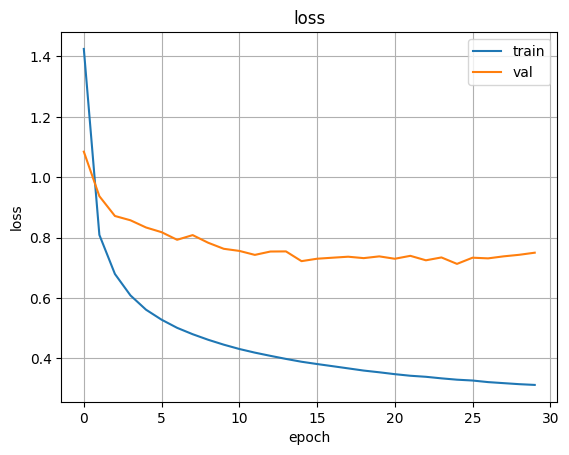

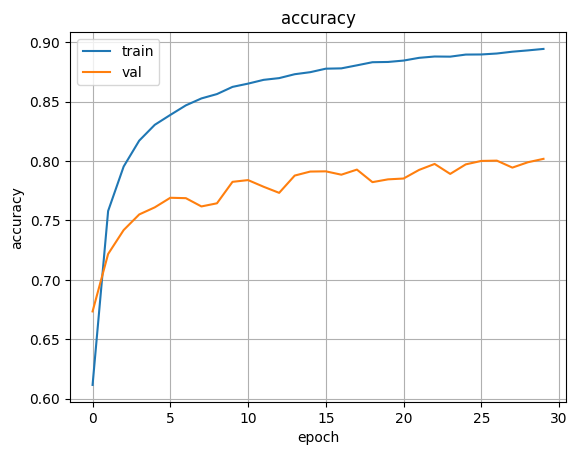

In [69]:
# Train
 
lstm_dense_training_info = {
    'verbose': 0,
    'epochs' : 30,
    'batch_size' : 64
}

lstm_dense_model = train_model(model=lstm_dense_model,training_info = lstm_dense_training_info)

In [70]:
loss, accuracy = lstm_dense_model.evaluate(x_val, y_val)
print(f"Model loss: {loss}, accuracy: {accuracy}")

# Inference and evaluate

lstm_dense_score = compute_f1(lstm_dense_model, x_val, y_val)
print(f'F1_score on the validation set is: {lstm_dense_score}')

lstm_dense_score = compute_f1(lstm_dense_model, x_test, y_test)
print(f'F1_score on the test set is: {lstm_dense_score}')

852/852 [==============================] - 11s 13ms/step - loss: 0.7497 - accuracy: 0.8019
Model loss: 0.7497055530548096, accuracy: 0.8019293546676636
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 27263 samples
426/426 [==============================] - 5s 10ms/step
F1_score on the validation set is: 0.6845514820968481
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 13614 samples
213/213 [==============================] - 2s 9ms/step
F1_score on the test set is: 0.75670710011766


## Conclusions